In [0]:
# Import all necessary libraries.
import numpy as np
import pandas as pd
import spacy
import string
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [0]:
# Load data.
df = pd.read_csv('comments_with_scores_and_features.csv')

In [4]:
# Review column list.
df.columns

Index(['id', 'by', 'author', 'time', 'time_ts', 'text', 'parent', 'deleted',
       'dead', 'ranking', 'neg', 'neu', 'pos', 'compound', 'tb_polarity',
       'tb_subjectivity', 'toxicity'],
      dtype='object')

In [0]:
# Define target column.
y = df['toxicity']

In [0]:
nlp = spacy.load('en_core_web_sm')

In [0]:
# Split data into train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(df['text'], 
                                                    y, 
                                                    train_size=0.8, 
                                                    random_state=0)

In [0]:
# Convert comment text to lowercase, remove punctuation, and trim 
# whitespace.
simple_text_train = X_train.str.lower()
simple_text_train = simple_text_train.str.replace('[{}]'.format(string.punctuation), '')
simple_text_train = simple_text_train.str.replace('\s+', ' ', regex=True)
simple_text_train = simple_text_train.str.strip()

simple_text_test = X_test.str.lower()
simple_text_test = simple_text_test.str.replace('[{}]'.format(string.punctuation), '')
simple_text_test = simple_text_test.str.replace('\s+', ' ', regex=True)
simple_text_test = simple_text_test.str.strip()

In [10]:
for text in simple_text_train.head():
    print(text, '\n')

without the safe harbor agreement you can no longer avoid eu privacy regulations by storing the data in the us maybe im missing something here my understanding is that the safe harbour agreement wasnt a mechanism for us companies to avoid eu data protection regulations it was a certification that they did comply with eu data protection particularly in situations where that data was transmitted outside the eu now its gone eu customer data held by us companies will be governed by national data protection laws instead so may end up having to be stored within the eu the us privacy regulations are no longer considered compatible with the eu privacy regulations i dont think they ever were which is why the safe harbour needed to exist in the first place 

imagine how much a interlispd smalltalk mesacedar workstation would have cost in the 70s versus a plain pdp11 eh if theyd put altos in serial production instead of small batches at a time adding up to 2000 units it wouldnt have been vastly m

In [0]:
tokens_train = simple_text_train.apply(nlp.tokenizer)
tokens_test = simple_text_test.apply(nlp.tokenizer)

In [0]:
# Lemmatize; remove stop words.
lemmas_train = tokens_train.apply(lambda x: [token.lemma_ for token in x if not token.is_stop])
lemmas_test = tokens_test.apply(lambda x: [token.lemma_ for token in x if not token.is_stop])

In [14]:
lemmas_train.head()

1362    [safe, harbor, agreement, long, avoid, eu, pri...
7304    [imagine, interlispd, smalltalk, mesacedar, wo...
4237    [thank, link, current, defacto, maintainer, pp...
3680                                [surely, rough, idea]
4780    [disclaimer, be, browser, engine, developer, f...
Name: text, dtype: object

In [15]:
# Instantiate vectorizer object.
tfidf = TfidfVectorizer(min_df=0.001, max_df=0.999)

# Create a vocabulary and get word counts per document.
dtm_train = tfidf.fit_transform(lemmas_train.astype(str))
dtm_test = tfidf.transform(lemmas_test.astype(str))

# Get feature names to use as dataframe column headers.
dtm_train_orig = pd.DataFrame(dtm_train.todense(), columns=tfidf.get_feature_names())
dtm_test_orig = pd.DataFrame(dtm_test.todense(), columns=tfidf.get_feature_names())

# Copy document term matrices.
dtm_train = dtm_train_orig.copy()
dtm_test = dtm_test_orig.copy()

# Preview feature matrix.
dtm_train.head()

,10,100,1000,101,10k,11,12,120,13,14,15,1500,16,18,1960s,1970s,1980s,1990s,1st,20,200,2000,2007,2008,2009,2010,2011,2012,2013,2014,2015,20th,21,22,23,24,25,28,2nd,30,...,wonderful,wood,word,wordpress,work,worker,workflow,workplace,workstation,world,worldwide,worry,worth,worthless,worthwhile,worthy,would,wow,wrap,write,writer,wrong,wrt,xerox,xss,yard,yc,year,yell,yep,yes,yesterday,yield,york,young,youth,youtube,zero,zillow,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.189891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.21561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.159473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
y_train_binary = (y_train > 0.7).astype(int)
y_test_binary = (y_test > 0.7).astype(int)

In [17]:
# Check target distribution.
np.bincount(y_train_binary)

array([7893,   83])

In [0]:
def count(docs):
    """
    Helper function for feature selection.
    """
    word_counts = Counter()
    appears_in = Counter()
    
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())
      
    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
    return wc.sort_values(by='rank')

In [19]:
# Find most common words in toxic comments.
toxic_wc_train = count(lemmas_train[y_train_binary.astype(bool)])
toxic_wc_train.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
3,not,35,46,1.0,0.019417,0.019417,0.421687
7,fuck,21,24,2.0,0.010131,0.029548,0.253012
34,people,22,24,3.0,0.010131,0.039679,0.265060
52,shit,21,23,4.0,0.009709,0.049388,0.253012
171,like,13,21,5.0,0.008864,0.058252,0.156627
56,s,15,20,6.0,0.008442,0.066695,0.180723
933,amazon,3,17,7.0,0.007176,0.073871,0.036145
40,time,13,16,8.0,0.006754,0.080625,0.156627
204,work,9,16,9.0,0.006754,0.087379,0.108434
100,have,11,15,10.0,0.006332,0.093710,0.132530


In [20]:
# Find most common words in non-toxic comments.
nontoxic_wc_train = count(lemmas_train[~y_train_binary.astype(bool)])
nontoxic_wc_train.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
7,not,2984,4872,1.0,0.019678,0.019678,0.378057
223,people,1485,2272,2.0,0.009177,0.028855,0.188141
371,like,1439,1900,3.0,0.007674,0.036530,0.182313
206,s,1246,1590,4.0,0.006422,0.042952,0.157861
34,think,1196,1508,5.0,0.006091,0.049043,0.151527
233,thing,985,1287,6.0,0.005198,0.054241,0.124794
217,work,887,1245,7.0,0.005029,0.059270,0.112378
49,time,880,1147,8.0,0.004633,0.063903,0.111491
250,use,826,1088,9.0,0.004395,0.068297,0.104650
27,have,887,1078,10.0,0.004354,0.072651,0.112378


In [0]:
# Make comparison table.
comp = pd.merge(toxic_wc_train[['word', 'appears_in_pct']], 
                nontoxic_wc_train[['word', 'appears_in_pct']], 
                how='outer', on='word', suffixes = ('_toxic', '_nontoxic'))

comp = comp.fillna(0)

comp['diff'] = abs(comp['appears_in_pct_toxic'] - comp['appears_in_pct_nontoxic'])

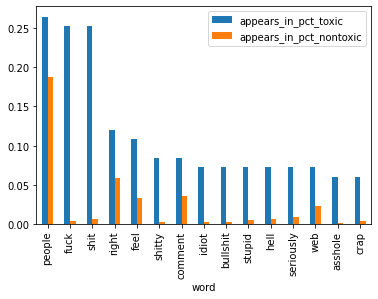

In [22]:
# Visualize words with the biggest frequency difference between comment
# categories.
top_15 = comp.sort_values(by='diff', ascending=False).head(15)
top_15.sort_values(by='appears_in_pct_toxic',
                   ascending=False).plot.bar(x='word',
                                             y=['appears_in_pct_toxic',
                                                'appears_in_pct_nontoxic']);

In [23]:
# Generate feature wordlist from comparison table.
autogen_wordlist = comp.sort_values(by='diff', ascending=False).head(229)['word']
list(autogen_wordlist)

['fuck',
 'shit',
 'shitty',
 'people',
 'feel',
 'idiot',
 'bullshit',
 'stupid',
 'hell',
 'seriously',
 'right',
 'asshole',
 'crap',
 'web',
 'comment',
 'man',
 'different',
 'ugly',
 'care',
 'read',
 'damn',
 'time',
 'honest',
 'not',
 'yes',
 'character',
 'way',
 'abuse',
 'terrible',
 'year',
 'hate',
 'begin',
 'new',
 'human',
 'want',
 'say',
 'mean',
 'interest',
 'change',
 'page',
 'search',
 'idiotic',
 'website',
 'datum',
 'product',
 'backwards',
 'come',
 'know',
 'real',
 'entire',
 'god',
 'case',
 'prime',
 'use',
 'matt',
 'criminal',
 'buy',
 'job',
 'tell',
 'fix',
 'think',
 'state',
 'font',
 'ui',
 'googles',
 'big',
 'tv',
 'black',
 'error',
 'help',
 'call',
 'complain',
 'stuff',
 'cost',
 'apple',
 'count',
 'sorry',
 'sure',
 'user',
 'support',
 'app',
 'death',
 'edit',
 'etc',
 'problem',
 'country',
 'little',
 'probably',
 'deal',
 'find',
 'happen',
 'microsoft',
 'look',
 'like',
 'leave',
 'language',
 'idea',
 'expect',
 'understand',
 'soc

In [0]:
# Feature wordlist without stop words.
autogen_wordlist = ['fuck',
                    'shit',
                    'shitty',
                    'people',
                    'feel',
                    'idiot',
                    'bullshit',
                    'stupid',
                    'hell',
                    'seriously',
                    'right',
                    'asshole',
                    'crap',
                    'web',
                    'comment',
                    'man',
                    'different',
                    'ugly',
                    'care',
                    'read',
                    'damn',
                    'time',
                    'honest',
                    'not',
                    'yes',
 'character',
 'way',
 'abuse',
 'terrible',
 'year',
 'hate',
 'begin',
 'new',
 'human',
 'want',
 'say',
 'mean',
 'interest',
 'change',
 'page',
 'search',
 'idiotic',
 'website',
 'datum',
 'product',
 'backwards',
 'come',
 'know',
 'real',
 'entire',
 'god',
 'case',
 'prime',
 'use',
 'matt',
 'criminal',
 'buy',
 'job',
 'tell',
 'fix',
 'think',
 'state',
 'font',
 'ui',
 'googles',
 'big',
 'tv',
 'black',
 'error',
 'help',
 'call',
 'complain',
 'stuff',
 'cost',
 'apple',
 'count',
 'sorry',
 'sure',
 'user',
 'support',
 'app',
 'death',
 'edit',
 'etc',
 'problem',
 'country',
 'little',
 'probably',
 'deal',
 'find',
 'happen',
 'microsoft',
 'look',
 'like',
 'leave',
 'language',
 'idea',
 'expect',
 'understand',
 'society',
 'poor',
 'provide',
 'go',
 'ask',
 'amazon',
  'pretty',
 'target',
 'include',
 'stop',
 'child',
 'public',
 'exactly',
 'term',
 'spit',
 'try',
 'issue',
 'information',
 'source',
 'youth',
 'safari',
 'constructive',
 'miss',
 'skin',
 'smell',
 'cop',
 'frustration',
 'suppose',
 'rest',
 'attractive',
 'similar',
 'sense',
 'discovery',
 'business',
 'assume',
 'low',
 'word',
 'true',
 'place',
 'guy',
 'lean',
 'eg',
 'reason',
 'animal',
 'transition',
 'index',
 'linus',
 'small',
 'shut',
 'vw',
 'campaign',
 'css',
 'guess',
 'actually',
 'override',
 'render',
 'cancer',
 'require',
 'mouse',
 'cheat',
 'to',
 'early',
 'mac',
 'send',
 'exclude',
 'test',
 'world',
 'screw',
 'car',
 'have',
 'service',
 'arm',
 'firefox',
 'claim',
 'defend',
 'wide',
 'straight',
 'designer',
 'burn',
 'file',
 'limit',
 'list',
 'google',
 'agree',
 'argument',
 'murder',
 'flag',
 'simple',
 'actual',
 'make',
 'hand',
 'eye',
 'tiny',
 'suck',
 'twice',
 'rarely',
 'javascript',
 'wall',
 'mistake',
 'perspective',
 'allow',
 'encourage',
 'feature',
 'andor',
 'fine',
 'forget',
 'logic',
 'internet',
 'difference',
 'especially',
 'damage',
 'security',
 'organization',
 'street',
 'free',
 'supply',
 'group',
 'display',
 'young',
 '10',
 'late']

In [25]:
len(autogen_wordlist)

220

In [0]:
dtm_train = dtm_train_orig[autogen_wordlist]
dtm_test = dtm_test_orig[autogen_wordlist]

In [0]:
model = keras.Sequential()

In [0]:
model.add(keras.layers.Dense(512, input_dim=220, activation='relu'))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam')

In [32]:
# Fit model.
model.fit(dtm_train, y_train_binary, epochs=25, 
          class_weight = {0: 0.010406, 1: 0.989594},
          validation_split=0.2, 
          verbose=False)

In [33]:
# Make predictions.
nn_train_pred = model.predict(dtm_train)
nn_test_pred = model.predict(dtm_test)
pd.DataFrame(nn_train_pred).describe()

,0
count,7.976000e+03
mean,3.480660e-02
std,1.191232e-01
min,4.574896e-23
25%,5.415649e-09
50%,3.472731e-06
75%,1.067579e-03
max,1.000000e+00


In [0]:
# Calculate metrics on training dataset.
train_accuracy = accuracy_score(y_train_binary, np.rint(nn_train_pred))
train_recall = recall_score(y_train_binary, np.rint(nn_train_pred))
train_precision = precision_score(y_train_binary, np.rint(nn_train_pred))

# Calculate metrics on test dataset.
test_accuracy = accuracy_score(y_test_binary, np.rint(nn_test_pred))
test_recall = recall_score(y_test_binary, np.rint(nn_test_pred))
test_precision = precision_score(y_test_binary, np.rint(nn_test_pred))

In [35]:
# Display metrics for training dataset.
print(f'Train accuracy: {train_accuracy:.4f}')
print(f'Train recall: {train_recall:.4f}')
print(f'Train precision: {train_precision:.4f}', '\n')

# Display metrics for test dataset.
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test recall: {test_recall:.4f}')
print(f'Test precision: {test_precision:.4f}')

Train accuracy: 0.9967
Train recall: 0.7952
Train precision: 0.8800 

Test accuracy: 0.9875
Test recall: 0.1000
Test precision: 0.2222


In [36]:
for text in X_test[np.rint(nn_test_pred).squeeze().astype(bool)]:
    print(text, '\n')

The author mentions working on Safari. Perhaps writing code to deal with other people's crap has something to do with her views. 

>  You well and truly are a piece of shit. You can't comment like this here. We've banned this account. 

Really means a lot. If you ever need a confidence boost though you should checkout 3000[0], I hear that developer is fucking killing it. [0]localhost:3000 

That's what I had people do. 

A link to this gist really should go in the OP by 'whoishiring. It's damn useful. 

If England hadn't kicked off the industrial revolution it might have taken another few centuries to start and you'd be shitting in a hole in the ground in the dark right now. So be grateful for the huge gift they gave all of us. 

Just tiny :P 

>  These threads always fucking suck on HN. Please don't post things like that to HN. They only make threads suck worse. 

If you want to render an element with transparency, you have to seperate it from the page and render it yourself with ctx.

In [37]:
for text in X_test[y_test_binary.astype(bool)]:
    print(text, '\n')

Once you take money from investors, you have both a legal and a moral responsibility to them. It's important to remember that selling equity is really selling something, just like selling a product. You can't sell something, take somebody's money, and then just not deliver. What you are selling to investors, generally, is return on investment. The real problem comes in because founders and VCs have different understandings of "grow fast". There will come choices that have different levels of risk. VCs always want you to take the high-risk, high-reward path, because they have a portfolio company and are looking for the few really big winners. You, on the other hand, are trying to build something (team, community, product, etc), and so you will favor slower but safer growth. I guess in theory you could sell VCs on a high-growth approach and then turn around and say, "Ha ha, fuck you, we're going to keep your money and try to grow modestly." But a) VCs are way better at their game than yo